<a href="https://colab.research.google.com/github/temurera/Deep-Learning/blob/master/VAE_for_Chaotic_Signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
!nvidia-smi

Tue Mar  8 16:25:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%cd "/content/drive/My Drive/PhD_4th_Semester/SHM_PoliMI" 

#%python VAE_pre_proc.py
#from VAE_pre_proc import * # Loading the undamaged dataset

/content/drive/My Drive/PhD_4th_Semester/SHM_PoliMI


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pickle
from scipy import *
from pylab import figure, show, setp
#from mpl_toolkits.mplot3d import Axes3D


In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [ ]:
latent_dim = 10
n_timesteps = 120
n_features = 1

encoder_inputs = keras.Input(shape=(n_timesteps,1,1))
x = layers.Reshape((120, 1, 1))(encoder_inputs)
x = layers.Conv1D(kernel_size = 3, filters = 16, activation="relu", strides=2, padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Conv1D(kernel_size = 7, filters = 32, activation="relu", strides=2, padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Conv1D(kernel_size = 9, filters = 64, activation="relu", strides=2, padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Conv1D(kernel_size = 9, filters = 10, activation="relu", strides=2, padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Flatten()(x)
#x = layers.Dense(16, activation="relu")(x)


z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 1, 1)]  0           []                               
                                                                                                  
 reshape (Reshape)              (None, 120, 1, 1)    0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 120, 1, 16)   64          ['reshape[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 120, 1, 16)  64          ['conv1d[0][0]']                 
 alization)                                                                                 

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
#x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = latent_inputs
x = layers.Reshape((latent_dim,1))(x)
x = layers.Conv1DTranspose(kernel_size = 15, filters = 64, activation="relu", strides=3, padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Conv1DTranspose(kernel_size = 11, filters = 32, activation="relu", strides=2, padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Conv1DTranspose(kernel_size = 9, filters = 16, activation="relu", strides=2, padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Conv1DTranspose(kernel_size = 5, filters = 1, activation="relu", strides=1, padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
#x = layers.Conv1DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = x#layers.Conv1DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 reshape_1 (Reshape)         (None, 10, 1)             0         
                                                                 
 conv1d_transpose (Conv1DTra  (None, 30, 64)           1024      
 nspose)                                                         
                                                                 
 batch_normalization_4 (Batc  (None, 30, 64)           256       
 hNormalization)                                                 
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 60, 32)           22560     
 ranspose)                                                       
                                                           

In [ ]:


#We define a function which is going to be the recursive function.
def num_rossler(x_n,y_n,z_n,h,a,b,c):
    x_n1=x_n+h*(-y_n-z_n)
    y_n1=y_n+h*(x_n+a*y_n)
    z_n1=z_n+h*(b+z_n*(x_n-c))   
    return x_n1,y_n1,z_n1

#Now we prepare some variables
#First the parameters
a=0.2
b=0.4
c=12

#Them the time interval and the step size
t_ini=0
t_fin=20000#32*pi
h=0.0125
numsteps=int((t_fin-t_ini)/h)

#using this parameters we build the time.
t=linspace(t_ini,t_fin,numsteps)
#And the vectors for the solutions
xx=zeros(numsteps)
yy=zeros(numsteps)
zz=zeros(numsteps)

#We set the initial conditions
xx[0]=1
yy[0]=1
zz[0]=1.05

for k in range(xx.size-1):
    #We use the previous point to generate the new point using the recursion
    [xx[k+1],yy[k+1],zz[k+1]]=num_rossler(xx[k],yy[k],zz[k],t[k+1]-t[k],a,b,c)
 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead


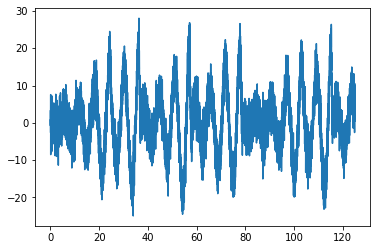

In [ ]:
noise = np. random. normal(0, 3, xx.shape)
yy = xx + noise

plt.plot(t[0:10000],yy[0:10000])

In [ ]:
rossler = yy[0:10000]

n_timesteps = 120*2
batch_size = 32

#for i in range(print(int((len(rossler)-n_timesteps)/n_timesteps))):
#    x_train = rossler[0:n_timesteps]
d_num = n_timesteps
hx = 10

#new_ = np.zeros([d_num,int(sample_size),sens_num])
dat = np.zeros([n_timesteps,(int((len(rossler)-n_timesteps)/hx))])
for i in range((int((len(rossler)-n_timesteps)/hx))):
      dat[:,i] = rossler[(hx*i):((hx*i)+d_num)]#/(np.max(np.abs(U[(hx*i):((hx*i)+d_num),1])))



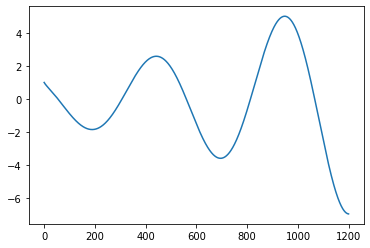

In [ ]:
plt.plot(xx[0:120])

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        #self.fnn_loss

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                    keras.losses.mean_squared_error(data, reconstruction)                
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss*100 + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    '''def call(self, inputs):
      z_mean, z_log_var, z = self.encoder(data)
      reconstruction = self.decoder(z)
      reconstruction_loss = tf.reduce_mean(keras.losses.mean_squared_error(data, reconstruction))
      kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
      kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
      total_loss = reconstruction_loss*100 + kl_loss
      self.add_metric(kl_loss, name="kl_loss", aggregation='mean')
      self.add_metric(total_loss, name="total_loss", aggregation='mean')
      self.add_metric(reconstruction_loss, name="reconstruction_loss", aggregation='mean')
      return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }'''

    def test_step(self, data):
        #if isinstance(data, tuple):
        #  data = data[0]

        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(keras.losses.mean_squared_error(data, reconstruction))
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss*100 + kl_loss
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    '''def test_step(self, data):
        # Unpack the data
        x, y = data
        # Compute predictions
        #self(x, training=False)
        #y_pred = self(x, training=False)
        [t1,t2,t3] = self.encoder(x ,training=False)
        y_pred = vae.decoder(t3)
        #print(tf.shape(out2))


        # Updates the metrics tracking the loss
        self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}'''



In [ ]:
vae = VAE(encoder, decoder)
#vae = tensorflow.keras.models.Model(vae_input, vae_decoder_output, name="VAE")


In [ ]:
vae.compile(optimizer=keras.optimizers.Adam(lr = 1e-3))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:


#dat = dat[0:120,:].reshape(dat.shape[1],120,1)
#dat = dat[0:120,:,:]


x_train = tf.data.Dataset.from_tensor_slices(dat[0:120,:].reshape(dat.shape[1],120,1))
dat1 = dat[:,0:720]
asd = tf.convert_to_tensor(
    dat1[0:120,:].reshape(dat1.shape[1],120,1), dtype=None, dtype_hint=None, name=None
)

dat2 = dat[:,720:900]
test = tf.convert_to_tensor(
    dat2[0:120,:].reshape(dat2.shape[1],120,1), dtype=None, dtype_hint=None, name=None
)


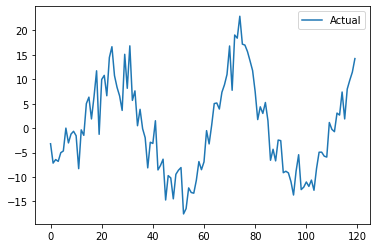

In [ ]:
#asd.shape 
#test.shape
asd_np = asd.numpy()
#plt.plot(out2_np[n_train,:,:], label='predicted')
plt.plot(asd_np[1,:,:], label='Actual')
#print(out2_np[0,:,:].shape)
plt.legend()


**Running the architecture to visualize the noisy results**

In [ ]:

#print((out2.numpy()).shape)
#plt.plot(o3)

#x_test = tf.data.Dataset.from_tensor_slices(dat[0:120,:].reshape(dat.shape[1],120,1))
asd1 = tf.convert_to_tensor(
    dat[0:120,0:240].reshape(240,120,1), dtype=None, dtype_hint=None, name=None
)


[o1,o2,o3] = vae.encoder(asd1)
out2 = vae.decoder(o3)
#print(tf.shape(out2))


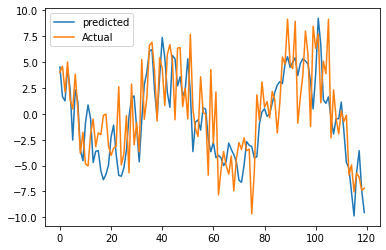

In [ ]:

n_train = 2
out2_np = out2.numpy()
asd2_np = asd1.numpy()
plt.plot(out2_np[n_train,:,:], label='predicted')
plt.plot(asd2_np[n_train,:,:], label='Actual')
#print(out2_np[0,:,:].shape)
plt.legend()

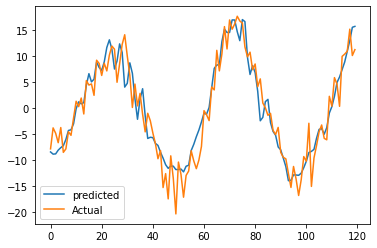

In [ ]:
n_train = 25
out2_np = out2.numpy()
asd2_np = asd1.numpy()
plt.plot(out2_np[n_train,:,:], label='predicted')
plt.plot(asd2_np[n_train,:,:], label='Actual')
#print(out2_np[0,:,:].shape)
plt.legend()